In [1]:
import tensorflow as tf
import random
import time
from datetime import datetime

tf.set_random_seed(20170101)

In [2]:
IMAGE_SIZE = 112
INPUT_SIZE = 96
DST_INPUT_SIZE = 56
NUM_CLASS = 5
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 5000
BATCH_SIZE = 100
LOGDIR='/tmp/data.%s' % datetime.now().isoformat()

KINDS = {
    0: 'バッグ',
    1: 'パンツ',
    2: 'シューズ',
    3: 'スカート',
    4: 'トップス'
}

print(LOGDIR)

def load(csv_files):
    file_queue = tf.train.string_input_producer(csv_files)
    reader = tf.TextLineReader()
    key, value = reader.read(file_queue)
    filename, label = tf.decode_csv(value, [['path'], [1]])

    label = tf.cast(label, tf.int64)
    label = tf.one_hot(label, depth = NUM_CLASS, on_value = 1.0, off_value = 0.0, axis = -1)
    
    jpeg = tf.read_file(filename)
    image = tf.image.decode_jpeg(jpeg, channels=3)
    image = tf.cast(image, tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])

    cropsize = random.randint(INPUT_SIZE, INPUT_SIZE + (IMAGE_SIZE - INPUT_SIZE) / 2)
    framesize = INPUT_SIZE + (cropsize - INPUT_SIZE) * 2
    image = tf.image.resize_image_with_crop_or_pad(image, framesize, framesize)
    image = tf.random_crop(image, [cropsize, cropsize, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.8)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.0)
    image = tf.image.random_hue(image, max_delta=0.04)
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)

    image = tf.image.resize_images(image, (DST_INPUT_SIZE, DST_INPUT_SIZE))
    image = tf.image.per_image_standardization(image)

    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * min_fraction_of_examples_in_queue)

    images, label_batch, filename = tf.train.shuffle_batch(
       [image, label, filename],
        batch_size=BATCH_SIZE,
        capacity=min_queue_examples + BATCH_SIZE * 3,
        min_after_dequeue=min_queue_examples,
        num_threads=8
    )

    tf.summary.image('image', images, max_outputs=100)
    labels = tf.reshape(label_batch, [BATCH_SIZE, NUM_CLASS])
    
    return (images, labels)

/tmp/data.2017-02-07T16:42:06.096459


In [3]:
def inference(images, keep_prob):
    
    x_image = tf.reshape(images, [-1, DST_INPUT_SIZE, DST_INPUT_SIZE, 3])

    with tf.name_scope('filter1'):        
        num_filters1 = 32

        W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 3, num_filters1], stddev = 0.1))
        b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
        h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
    
    with tf.name_scope('pool1'):
        h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)
        h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    with tf.name_scope('fc1'):
        w = int(DST_INPUT_SIZE / 2)
        h_pool1_flat = tf.reshape(h_pool1, [-1, w*w*num_filters1])

        num_units1 = w*w*num_filters1
        num_units2 = 1024

        w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
        b2 = tf.Variable(tf.constant(0.1, shape=[num_units2])) 
        hidden２ = tf.nn.relu(tf.matmul(h_pool1_flat, w2) + b2)
        
        hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
        
        w0 = tf.Variable(tf.zeros([num_units2, 5]))
        b0 = tf.Variable(tf.zeros([5]))
        
        tf.summary.histogram('weights_output', w0)
        tf.summary.histogram('biases_output', b0)
        
    with tf.name_scope('sotmax'):
        p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)
        
    return p, W_conv1, h_conv1

In [4]:
def loss(p, labels):
    #loss = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(p, 1e-10, 1.0)))
    loss = -tf.reduce_sum(labels * tf.log(p))
    
    tf.summary.scalar('loss', loss)
    
    return loss

In [5]:
def accuracy(p, labels):
    correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.summary.scalar('accuracy', accuracy)
    
    return accuracy

In [6]:
def optimizer(loss):
    train_step = tf.train.AdamOptimizer(1e-5).minimize(loss)

    return train_step

In [7]:
with tf.Graph().as_default():
    images, labels = load(['train.csv'])
    keep_prob = tf.placeholder(tf.float32)
    p, w_conv, h_conv = inference(images, keep_prob=keep_prob)
    loss = loss(p, labels)
    train_step = optimizer(loss)
    accuracy = accuracy(p, labels)
    
    saver = tf.train.Saver()
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    tf.train.start_queue_runners(sess)
    
    summary = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(LOGDIR, sess.graph)
        
    for step in range(101):
        start_time = time.time()
        _, loss_val, acc_val = sess.run([train_step, loss, accuracy], feed_dict={keep_prob: 0.5})
        duration = time.time() - start_time

        if step % 10 == 0:
            loss_val, acc_val = sess.run([loss, accuracy], feed_dict={keep_prob: 1.0})
            print('Step: %d, Loss: %.2f, Accuracy: %f' % (step, loss_val, acc_val))
            
            summary_str = sess.run(summary, feed_dict={keep_prob: 1.0})
            summary_writer.add_summary(summary_str, step)

        if step % 100 == 0:
            saver.save(sess, 'study_cnn_sample_1', global_step=step)

Step: 0, Loss: 161.78, Accuracy: 0.160000
Step: 10, Loss: 142.42, Accuracy: 0.380000
Step: 20, Loss: 126.02, Accuracy: 0.510000
Step: 30, Loss: 119.99, Accuracy: 0.500000
Step: 40, Loss: 101.90, Accuracy: 0.670000
Step: 50, Loss: 106.42, Accuracy: 0.580000
Step: 60, Loss: 97.21, Accuracy: 0.640000
Step: 70, Loss: 106.57, Accuracy: 0.590000
Step: 80, Loss: 92.45, Accuracy: 0.690000
Step: 90, Loss: 87.11, Accuracy: 0.720000
Step: 100, Loss: 88.41, Accuracy: 0.710000


In [8]:
def evaluation(image_path, ckpt_path):
    tf.reset_default_graph()

    jpeg = tf.read_file(image_path)
    image = tf.image.decode_jpeg(jpeg, channels=3)
    image = tf.cast(image, tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.image.resize_images(image, [DST_INPUT_SIZE, DST_INPUT_SIZE])
    image = tf.image.per_image_standardization(image)
    image = tf.reshape(image, [-1,DST_INPUT_SIZE * DST_INPUT_SIZE * 3])

    p, w_conv, h_conv = inference(image, 1.0)

    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_path)

    results = sess.run(p)

    result = results[0]
    rates = [round(n * 100.0, 1) for n in result]

    pred = np.argmax(result)

    ranking = []
    for idx, rate in enumerate(rates):
        name = KINDS[idx]
        ranking.append({
            'image': image_path,
            'kind': name,
            'rate': rate
        })
    rank = sorted(ranking, key=lambda x: x['rate'], reverse=True)

    return (rank, pred)

In [9]:
evaluation('resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg', './study_cnn_sample_1-100')

([{'image': 'resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg',
   'kind': 'バッグ',
   'rate': 41.600000000000001},
  {'image': 'resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg',
   'kind': 'トップス',
   'rate': 24.399999999999999},
  {'image': 'resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg',
   'kind': 'スカート',
   'rate': 13.9},
  {'image': 'resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg',
   'kind': 'シューズ',
   'rate': 12.300000000000001},
  {'image': 'resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg',
   'kind': 'パンツ',
   'rate': 7.7000000000000002}],
 0)

In [10]:
def display(image_path, ckpt_path):
    tf.reset_default_graph()

    jpeg = tf.read_file(image_path)
    image = tf.image.decode_jpeg(jpeg, channels=3)
    image = tf.cast(image, tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.image.resize_images(image, [DST_INPUT_SIZE, DST_INPUT_SIZE])
    image = tf.image.per_image_standardization(image)
    image = tf.reshape(image, [-1,DST_INPUT_SIZE * DST_INPUT_SIZE * 3])

    p, w_conv, h_conv = inference(image, 1.0)
    
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_path)
    
    filter_vals, conv_vals = sess.run([w_conv, h_conv])
    
    fig = plt.figure(figsize=(2,33))

    for i in range(32):
        subplot = fig.add_subplot(33, 2, 2 * (i + 1) + 1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(filter_vals[:, :, 0, i], interpolation='nearest')
        
        subplot = fig.add_subplot(33, 2, 2  * (i + 1) + 2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_vals[0, :, :, i], interpolation='nearest')      
            
    plt.show()

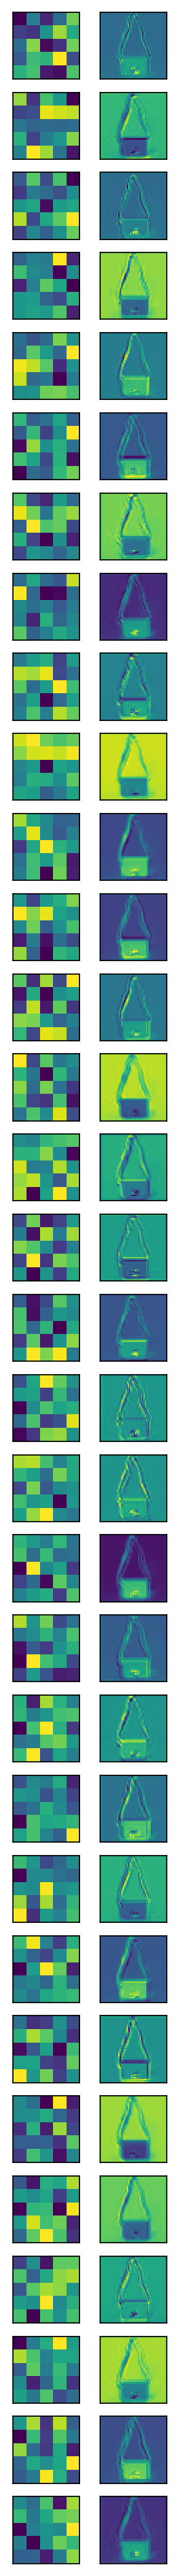

In [11]:
display('resize/out/test/bags/coordisnap-items-1646784-909236-2qspp7.jpg', './study_cnn_sample_1-100')